<a href="https://colab.research.google.com/github/lizzzb/Collaborative-Filtering-Algo-for-RecommenderSystems/blob/main/ALS_for_CF_from_RecommendersGitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark Collaborative Filtering (ALS) Deep Dive

Spark MLlib provides a collaborative filtering algorithm that can be used for training a matrix factorization model, which predicts explicit or implicit ratings of users on items for recommendations.

This notebook presents a deep dive into the Spark collaborative filtering algorithm.

## 1 Matrix factorization algorithm

### 1.1 Matrix factorization for collaborative filtering problem

Matrix factorization is a common technique used in recommendation tasks. Basically, a matrix factorization algorithm tries to find latent factors that represent intrinsic user and item attributes in a lower dimension. That is,

$$\hat r_{u,i} = q_{i}^{T}p_{u}$$

where $\hat r_{u,i}$ is the predicted ratings for user $u$ and item $i$, and $q_{i}^{T}$ and $p_{u}$ are latent factors for item and user, respectively. The challenge to the matrix factorization problem is to find $q_{i}^{T}$ and $p_{u}$. This is achieved by methods such as **matrix decomposition**. A learning approach is therefore developed to converge the decomposition results close to the observed ratings as much as possible. Furthermore, to avoid overfitting issue, the learning process is **regularized**. For example, a basic form of such matrix factorization algorithm is represented as below.

$$\min\sum(r_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $\lambda$ is a the regularization parameter,

$r_{u,i}$​: This is the known rating given by user $u$ to item $i$,

$q_{i}$​: This is the latent factor vector for item ii, capturing its characteristics,

$p_{u}$​: This is the latent factor vector for user uu, capturing their preferences,

$q_{i}^{T}p_{u}​$: represents the predicted rating that user uu would give to item $i$,

$λ$: This is a regularization parameter to prevent overfitting by penalizing the size of $q_{i}$​ and pupu​.

The goal is to minimize the difference between the actual rating ru,iru,i​ and the predicted rating $q_{i}^{T}p_{u}​$​, while also keeping the latent vectors small (via regularization).

**In case explict ratings are not available, implicit ratings which are usually derived from users' historical interactions with the items (e.g., clicks, views, purchases, etc.) are used.** To account for such implicit ratings, the original matrix factorization algorithm can be formulated as

$$\min\sum c_{u,i}(p_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $c_{u,i}=1+\alpha r_{u,i}$ and $p_{u,i}=1$ if $r_{u,i}>0$ and $p_{u,i}=0$ if $r_{u,i}=0$. $r_{u,i}$ is a numerical representation of users' preferences (e.g., number of clicks, etc.).

In the implicit case, $r_{u,i}$​ represents interaction data instead of a rating. This could be the number of clicks, views, purchases, or any other form of interaction between the user and item. Unlike explicit ratings, these interactions do not directly tell us whether the user liked or disliked the item. For instance, a high number of clicks could mean interest, but it might also be due to curiosity without a strong preference.
Implicit feedback is therefore indirect and often noisier, requiring additional handling like confidence scores  $c_{u,i}$​ to weight each interaction's importance.

$c_{u,i}$ helps the model determine how strongly to weigh each interaction. Higher interaction counts indicate greater confidence in user interest, and the model should focus more on fitting these pairs.

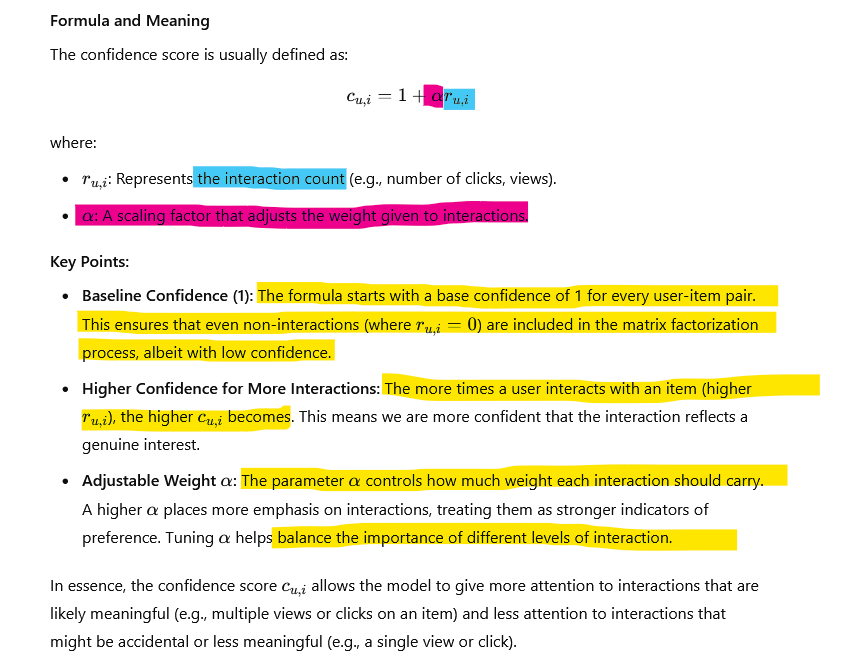


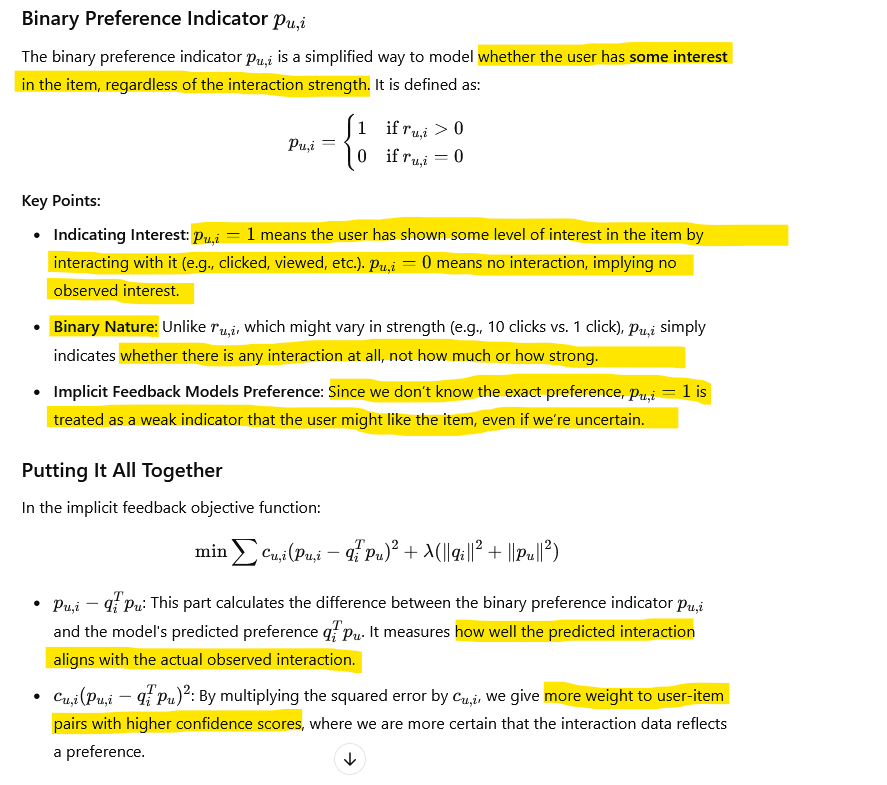


### 1.2 Alternating Least Square (ALS)

Owing to the term of $q_{i}^{T}p_{u}$ the loss function is non-convex. Gradient descent method can be applied but this will incur *expensive computations*. An Alternating Least Square (ALS) algorithm was therefore developed to overcome this issue.

The basic idea of ALS is to learn one of $q$ and $p$ at a time for optimization **while keeping the other as constant**. This makes the objective at each iteration convex and solvable. The alternating between $q$ and $p$ stops when there is convergence to the optimal. It is worth noting that this iterative computation can be parallelised and/or distributed, which makes the algorithm desirable for use cases where the dataset is large and thus the user-item rating matrix is super sparse (as is typical in recommendation scenarios). A comprehensive discussion of ALS and its distributed computation can be found [here](http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf).

## 2 Spark Mllib implementation

The matrix factorization algorithm is available as `ALS` module in [Spark `ml`](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) for DataFrame or [Spark `mllib`](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html) for RDD.

* The uniqueness of ALS implementation is that it distributes the matrix factorization model training by using "Alternating Least Square" method.
* In the training method, there are parameters that can be selected to control the model performance.
* **Both explicit and implicit ratings are supported by Spark ALS model.**

## 3 Spark ALS based MovieLens recommender

In the following code, the MovieLens-100K dataset is used to illustrate the ALS algorithm in Spark.

**Note**: This notebook requires a PySpark environment to run properly. Please follow the steps in [SETUP.md](https://github.com/Microsoft/Recommenders/blob/master/SETUP.md#dependencies-setup) to install the PySpark environment.

In [1]:
!pip install recommenders

  Using cached pandera-0.20.4-py3-none-any.whl.metadata (15 kB)
Using cached pandera-0.20.4-py3-none-any.whl (259 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.7.1
    Uninstalling pandera-0.7.1:
      Successfully uninstalled pandera-0.7.1


In [2]:

pip install pandera==0.7.1

  Using cached pandera-0.7.1-py3-none-any.whl.metadata (10 kB)
Using cached pandera-0.7.1-py3-none-any.whl (165 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.20.4
    Uninstalling pandera-0.20.4:
      Successfully uninstalled pandera-0.20.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
recommenders 1.2.0 requires pandera[strategies]>=0.15.0; python_version >= "3.9", but you have pandera 0.7.1 which is incompatible.


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType

from recommenders.datasets import movielens
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"PySpark version: {pyspark.__version__}")


System version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Pandas version: 2.2.2
PySpark version: 3.5.3


In [6]:
## Data column names

MOVIELENS_DATA_SIZE = "100k"

COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_RATING = "Rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "Timestamp"

In [7]:
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

This code defines a **schema** for a dataset using **PySpark's** `StructType` and `StructField` classes. A schema is essentially a blueprint that tells PySpark the data types of each column in a DataFrame, which is particularly useful when loading data from sources where types might not be automatically inferred.

Here’s a breakdown of each part of the schema:

1. **StructType**: This is the container for a list of fields (columns) in the schema.
2. **StructField**: This defines individual columns, specifying their names and data types.

Explanation of Each Field
- **`COL_USER`**: The column name for users, defined as `IntegerType()`, meaning it should contain integer values (e.g., user IDs).
- **`COL_ITEM`**: The column name for items, also of type `IntegerType()`, so it expects integer values (e.g., item IDs).
- **`COL_RATING`**: The column name for ratings, defined as `FloatType()`, meaning it should contain floating-point numbers (e.g., user ratings).
- **`COL_TIMESTAMP`**: The column name for timestamps, defined as `LongType()`, so it expects long integer values (e.g., Unix timestamps).

The `schema` object created here can then be passed to a DataFrame when loading data, which will ensure the data conforms to the specified structure. For instance:

```python
df = spark.read.csv("path_to_data.csv", schema=schema)
```

This schema is especially useful for recommendation systems, where you typically have user, item, rating, and time information.

Model hyper parameters - these parameters are selected with reference to the benchmarking results [here](http://mymedialite.net/examples/datasets.html).

In [9]:
# Define model hyperparameters

RANK = 10
MAX_ITER = 15
REG_PARAM = 0.05

# Number of recommended items
K = 10

`RANK (10)`

  * Latent Factors: RANK represents the number of latent factors, or hidden features, used to represent users and items in the model. These factors capture underlying patterns and preferences that influence user-item interactions.
  * Balance between Complexity and Performance: A higher rank can capture more complex relationships but might lead to overfitting and increased computational cost. A lower rank simplifies the model but might not capture all the nuances in the data.
  * Benchmarking and Empirical Evidence: The value of 10 is often chosen based on benchmarking studies and empirical evidence from various recommendation systems. It generally provides a good balance between accuracy and efficiency, especially for datasets like MovieLens.
  * Starting Point: It's often considered a reasonable starting point for exploration and can be further tuned based on specific dataset characteristics and evaluation metrics.

`MAX_ITER (15)`

   * Iterations for Convergence: MAX_ITER determines **the maximum number of iterations the ALS algorithm will run to converge to a solution**. Each iteration updates the model's parameters to minimize the error in predicting user ratings.
   * Trade-off between Accuracy and Time: More iterations can lead to better accuracy but require more computation time. Fewer iterations might converge faster but potentially sacrifice some accuracy.
   * Diminishing Returns: Beyond a certain point, increasing the number of iterations might not significantly improve the model's performance, exhibiting diminishing returns.
   * Common Practice and Empirical Observation: 15 iterations is a common choice based on practical experience and empirical observations. It often allows the algorithm to converge sufficiently without excessive computational overhead.

`REG_PARAM (0.05)`

  * Regularization to Prevent Overfitting: REG_PARAM controls the regularization strength, which is used to prevent overfitting. Overfitting occurs when the model learns the training data too well and performs poorly on unseen data.
  * Balancing Model Complexity: Regularization penalizes large parameter values, encouraging the model to find a simpler solution that generalizes better.
  * Impact on Bias-Variance Trade-off: A higher regularization parameter reduces model complexity and variance but might increase bias. A lower value allows for more complex models but increases the risk of overfitting.
  * Empirical Tuning and Cross-Validation: 0.05 is often chosen as a starting point and **can be fine-tuned using techniques like cross-validation** to find the optimal value for a specific dataset.

 `K = 10` means that your system will aim to provide each user with a list of 10 recommended items.

In [10]:
# Initialize a Spark session
spark = start_or_get_spark("ALS Deep Dive", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/26 13:06:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


The code initializes a **Spark session** with a specified application name ("ALS Deep Dive") and memory configuration (`memory="16g"`). Then, it sets a specific configuration option: `spark.sql.analyzer.failAmbiguousSelfJoin`.

Explanation of `spark.sql.analyzer.failAmbiguousSelfJoin`

Setting `spark.sql.analyzer.failAmbiguousSelfJoin` to `"false"` affects how Spark handles **self-joins** in SQL queries.

- **Self-join**: A self-join is a join operation where **a table is joined with itself**. This is common in scenarios where you need to compare rows within the same table, such as finding pairs of items, comparing user interactions, or calculating similarity.

- **Ambiguity Issue in Self-Joins**: When you join a table with itself, there can be ambiguity in column names, especially if you haven’t specified unique aliases. This can cause issues for Spark's SQL analyzer, which may not be able to resolve the query because it doesn't know which column to refer to.

- **`failAmbiguousSelfJoin = false`**: By setting this option to `"false"`, you’re telling Spark not to throw an error when it encounters an ambiguous column name in a self-join. Instead, Spark will attempt to execute the query without failing, though it may not resolve the ambiguity perfectly, so it’s still a good practice to use unique aliases for each column in your joins.

Example

Suppose you have a DataFrame `df` with a column `id`, and you perform a self-join like this:
```python
df.join(df, on="id")
```
Without explicit column aliases, Spark would have trouble distinguishing between `id` columns from the left and right sides of the join. If `failAmbiguousSelfJoin` were set to `"true"` (the default), Spark would throw an error. By setting it to `"false"`, Spark allows the query to proceed, but it’s often better to explicitly handle potential ambiguities to avoid unexpected results.

When to Use It

This setting is typically used when:
- You’re working with complex queries involving self-joins, and you prefer to handle ambiguities yourself.
- You need flexibility in query execution but understand the risk of potentially ambiguous results.

However, it’s generally good practice to handle self-joins carefully with column aliases to ensure that the logic of your query is clear.

### 3.1 Load and prepare data

In [11]:
# Data is read from csv into a Spark DataFrame.
dfs = movielens.load_spark_df(spark=spark, size=MOVIELENS_DATA_SIZE, schema=schema)
dfs.show(15)

100%|██████████| 4.81k/4.81k [00:01<00:00, 3.07kKB/s]


+------+-------+------+---------+
|UserId|MovieId|Rating|Timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
|   298|    474|   4.0|884182806|
|   115|    265|   2.0|881171488|
|   253|    465|   5.0|891628467|
|   305|    451|   3.0|886324817|
|     6|     86|   3.0|883603013|
|    62|    257|   2.0|879372434|
|   286|   1014|   5.0|879781125|
|   200|    222|   5.0|876042340|
|   210|     40|   3.0|891035994|
|   224|     29|   3.0|888104457|
+------+-------+------+---------+
only showing top 15 rows



In [12]:
# Data is then randomly split by 80-20 ratio for training and testing.
dfs_train, dfs_test = spark_random_split(dfs, ratio=0.8, seed=42)

### 3.2 Train a movielens model

In this context, the **Spark ALS model** (Alternating Least Squares) in PySpark has a feature that allows you to **drop cold users** during the evaluation phase. Let’s break down what that means and why it’s important.

**Key Concepts**

1. **Cold Users**: In recommendation systems, cold users are users who are **new** or have **very little interaction data** in the training set. This lack of data makes it challenging to create accurate recommendations for them because the model hasn't learned much about their preferences.

2. **ALS Model in Spark**: Spark's ALS model is a matrix factorization method used for collaborative filtering. It requires a certain amount of interaction data (like ratings or clicks) to learn user and item embeddings effectively. When data is sparse, as in the case of cold users, the model struggles to make accurate predictions.

3. **Robust Evaluation**: A robust evaluation means evaluating the model in a way that gives reliable insights into its performance. If we include cold users in the test data, the evaluation might not be entirely fair or accurate, as the model has had little opportunity to learn about these users.

The Spark ALS model allows you to **exclude cold users from the evaluation process** to get a more reliable assessment of its performance.

- **Why Drop Cold Users?**: If cold users are included in the evaluation, they can skew the performance metrics (e.g., accuracy, precision) since the model naturally struggles with them. By dropping these users from the evaluation, you focus only on users who have sufficient interaction data in the training set, giving you a more realistic view of how well the model performs for "known" users.
  
- **When to Drop Cold Users**: This is especially useful when you’re evaluating the model’s performance for a subset of users who have enough historical data. Dropping cold users prevents the evaluation from being affected by users with limited information, making the results more **representative of the model’s true capabilities**.

In summary:
- **Without Dropping Cold Users**: The evaluation may reflect lower performance due to cold-start issues, which aren’t necessarily indicative of the model’s general accuracy.
- **With Dropping Cold Users**: The evaluation focuses on users the model knows well, offering a clearer picture of performance for "warm" users.

By leveraging this feature, you get a **sounder evaluation** that reflects the model's ability to predict for users with enough data, rather than being skewed by users it has insufficient information on.

In [13]:
als = ALS(maxIter=MAX_ITER,
          rank=RANK,
          regParam=REG_PARAM,
          userCol=COL_USER,
          itemCol=COL_ITEM,
          ratingCol=COL_RATING,
          coldStartStrategy="drop")
model = als.fit(dfs_train)

### 3.3 Prediction with the model


In [15]:
dfs_pred = model.transform(dfs_test).drop(COL_RATING)
dfs_pred.show(20)

+------+-------+---------+----------+
|UserId|MovieId|Timestamp|prediction|
+------+-------+---------+----------+
|   148|      8|877020297| 3.8150504|
|   148|     56|877398212| 3.3400514|
|   148|     71|877019251| 3.6513672|
|   148|    133|877019251|  2.776179|
|   148|    169|877020297|  4.944927|
|   148|    172|877016513| 4.6943893|
|   148|    194|877015066|  4.461259|
|   148|    222|877398901| 3.7592487|
|   148|    357|877016735| 3.2883487|
|   148|    432|877019698|  4.112928|
|   148|    474|877019882|  4.317418|
|   148|    529|877398901|  4.217235|
|   148|    588|877399018| 3.2863073|
|   148|    713|877021535|  3.854576|
|   463|     24|877385731| 2.6154478|
|   463|     50|890530818| 3.5792081|
|   463|    117|877385731| 3.2281814|
|   463|    124|877385381| 3.3979568|
|   463|    147|877386047| 2.2920735|
|   463|    149|877385341| 1.0542068|
+------+-------+---------+----------+
only showing top 20 rows



### 3.3.1. Evaluation

In [17]:
evaluations = SparkRatingEvaluation(
    dfs_test,
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)

RMSE score = 0.9561137478987034
MAE score = 0.7458083670167803
R2 score = 0.28028528515244766
Explained variance score = 0.28450798618557405


* RMSE and MAE are error-based metrics, showing the average deviation of predictions from actual values.
* R2 and Explained Variance tell us how well the model explains the variance in the data.

RMSE (Root Mean Squared Error): Measures the average squared difference between predicted and actual ratings. Lower RMSE values indicate better predictions.

MAE (Mean Absolute Error): Calculates the average absolute difference between predicted and actual ratings. It’s a straightforward measure of prediction accuracy, with lower values indicating more accurate predictions.

R2 (R-squared): Measures the proportion of the variance in the actual ratings that is predictable from the predicted ratings. It ranges from 0 to 1, where values closer to 1 indicate better performance.

Explained Variance: Represents the variance in the actual ratings explained by the model. Higher values (closer to 1) indicate that the model is good at explaining the observed data.

### 3.3.2. Ranking


Ranking is a problem in machine learning where the objective is to sort a list of documents for an end user in the most suitable way, so the most relevant documents appear on top.

[Nice explanation of ranking technics.](https://www.linkedin.com/pulse/search-ranking-evaluation-metrics-kailash-thiyagarajan/)

----
**Evaluation Metrics:** Measure the overall performance and accuracy of recommendations, focusing on binary relevance (i.e., whether items are relevant or not).

**Ranking Metrics:** Assess how well the system orders or prioritizes recommended items, focusing on the relevance and position of items in the recommendation list.

----
**Evaluation Metrics:** Do not consider the order of items in the list; they only check if recommended items are relevant.

**Ranking Metrics:** Place emphasis on the ordering of items, giving higher importance to items at the top of the list (since users are more likely to see and interact with these).

----
**Evaluation Metrics:** Mean Squared Error (MSE), Mean Absolute Error (MAE), Precision, Recall, and F1 Score.

**Ranking Metrics:** Normalized Discounted Cumulative Gain (NDCG), Mean Reciprocal Rank (MRR), Average Precision (AP), Recall@K and Precision@K.

The goal of this code is to **prepare data for ranking evaluation in a recommendation system**. Here’s a high-level overview of why each step is necessary and what you’re ultimately achieving:

1. **Generate All Possible User-Item Pairs**:
   - In a recommendation system, you typically want to recommend items that a user hasn’t seen before.
   - Generating all possible pairs (every user with every item) lets you *evaluate which items might be relevant to each user, even if the user hasn’t interacted with them yet.*

2. **Predict Scores for All User-Item Pairs**:
   - Once you have the full set of possible user-item pairs, you use your model to *assign a prediction score to each pair*.
   - This score represents the model's estimate of how much each user might like each item, which is necessary for ranking.

3. **Remove Items the User Has Already Seen**:
   - Since recommendation systems typically aim to introduce *new or relevant content to the user*, you want to exclude any items the user has already interacted with.
   - By joining with the user’s historical data (`dfs_train`) and filtering out items the user has already rated, you ensure that only unseen items are recommended and evaluated.

4. **Evaluate Ranking Metrics on Unseen Items**:
   - After removing seen items, `dfs_pred_final` now holds a set of unseen items with predicted scores, which is *perfect for evaluating* **ranking metrics**.
   - Ranking metrics (like NDCG, Precision@K) require a ranked list of items, ideally sorted by how much the user would like them.
   - This final list lets you assess **how well the model ranks relevant (unseen) items for each user, which is a key measure of recommendation quality.**

*Why This Matters*
In real-world recommendation systems, it’s essential to recommend only new, potentially relevant items to users. The purpose of these steps is to **create a ranked list of recommendations for each user that excludes items they’ve already interacted with**. By doing this, you can more accurately evaluate the model’s performance in a practical, user-focused scenario and ensure the recommendations provide a fresh experience.

In [22]:
# Get the cross join of all user-item pairs and score them.
users = dfs_train.select(COL_USER).distinct()
items = dfs_train.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)
dfs_pred = model.transform(user_item)

# Remove seen items
dfs_pred_exclude_train = dfs_pred.alias("pred").join(
    dfs_train.alias("train"),
    (dfs_pred[COL_USER] == dfs_train[COL_USER]) & (dfs_pred[COL_ITEM]== dfs_train[COL_ITEM]), how='left_anti'
)


dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()).select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")


24/10/26 14:34:08 WARN Column: Constructing trivially true equals predicate, 'UserId#0 = UserId#0'. Perhaps you need to use aliases.


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `train`.`Rating` cannot be resolved. Did you mean one of the following? [`UserId`, `MovieId`, `prediction`].

* Aliases: By using alias("pred") and alias("train"), Spark can differentiate between columns in dfs_pred and dfs_train.
* left_anti join: This join type removes rows in dfs_pred that have a matching row in dfs_train, keeping only user-item pairs where the user has not interacted with the item before.


```python
dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")
```

This line performs two main operations: **filtering out seen items** and **selecting specific columns**. Let’s break it down:

**Step-by-Step Explanation**

1. **Filtering Out Seen Items**:
   ```python
   dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull())
   ```
   - Here, `dfs_pred_exclude_train` is the result of a join between `dfs_pred` (predictions for all user-item pairs) and `dfs_train` (user-item interactions the user has already rated).
   - `train.Rating` refers to the rating column from `dfs_train`, which indicates that a user has already seen and rated that item.
   - By using `filter(dfs_pred_exclude_train["train.Rating"].isNull())`, we keep only the rows where `train.Rating` is `Null`, meaning these are the user-item pairs **not present in `dfs_train`**.
   - This effectively **excludes items the user has already interacted with**, so only unseen items remain in the final dataset.

2. **Selecting Specific Columns**:
   ```python
   .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")
   ```
   - After filtering, we select the specific columns we need: the user ID, item ID, and the predicted rating or score.
   - Since `dfs_pred` was aliased as `"pred"` in the join, we can access columns from `dfs_pred` by using the `"pred."` prefix. This line extracts:
     - **`pred.COL_USER`**: the user ID from the predictions DataFrame.
     - **`pred.COL_ITEM`**: the item ID from the predictions DataFrame.
     - **`pred.prediction`**: the prediction score for each user-item pair.

**Summary of What This Line Achieves**

This line produces `dfs_pred_final`, a DataFrame that contains:
- User-item pairs where the item is unseen by the user.
- A prediction score indicating how likely the user is to engage with each item.

This is the final dataset for evaluating your model’s recommendations for each user, only including new (unseen) items.

Great question! Using an `outer` join alone doesn’t directly remove seen items—it only combines the data in a way that lets us identify and filter them out afterward. Here’s why both the join **and** the filter step are necessary in this code:

### Step 1: `outer` Join

The `outer` join here is meant to align two tables:
1. **`dfs_pred`**: contains predictions for every possible user-item pair.
2. **`dfs_train`**: contains only the user-item pairs the user has actually interacted with (rated).

By doing an `outer` join, you end up with:
- Rows where there’s a match in both tables (i.e., the user has already seen and rated the item).
- Rows where there’s no match in `dfs_train` (i.e., items the user hasn’t seen or rated).

Each row will have data from `dfs_train` if the user has rated the item. If they haven’t, then the `Rating` column from `dfs_train` will be `Null`.

### Step 2: Filtering Based on `train.Rating.isNull()`

After the `outer` join, the `filter` operation is applied to **keep only rows where `train.Rating` is `Null`**. This is necessary because:
- Rows where `train.Rating` is `Null` represent user-item pairs the user hasn’t rated yet, which are the items we want to recommend.

**Without the filter step, the result would contain both seen and unseen items, defeating the purpose of creating a list of *only* unseen recommendations.**

### Why Not Just Use an `outer` Join?
The `outer` join alone doesn’t remove the seen items—it just combines the tables and leaves markers (like `Null` values) that allow us to identify seen vs. unseen items. The filter step then completes the process by discarding the seen items.

### Alternative: Using `left_anti` Join Instead

**As mentioned earlier, a more efficient approach would be to use a `left_anti` join, which directly removes seen items. With `left_anti`, you don’t need to do any filtering afterward because it keeps only rows from `dfs_pred` where there’s no match in `dfs_train`.**

Here’s how it would look:

```python
# Remove seen items using left_anti join directly
dfs_pred_final = dfs_pred.alias("pred").join(
    dfs_train.alias("train"),
    (dfs_pred[COL_USER] == dfs_train[COL_USER]) & (dfs_pred[COL_ITEM] == dfs_train[COL_ITEM]),
    how='left_anti'  # Keeps only rows in dfs_pred that don't have matches in dfs_train
).select("pred." + COL_USER, "pred." + COL_ITEM, "pred." + "prediction")
```

### Summary

The original code uses an `outer` join and a filter because:
- The `outer` join aligns the data but doesn’t remove seen items by itself.
- The `filter` removes the seen items by checking for `Null` ratings.

**Alternatively, the `left_anti` join does both in one step, making it more concise and efficient.**

In [24]:
# Remove seen items using left_anti join directly
dfs_pred_final = dfs_pred.alias("pred").join(
    dfs_train.alias("train"),
    (dfs_pred[COL_USER] == dfs_train[COL_USER]) & (dfs_pred[COL_ITEM] == dfs_train[COL_ITEM]),
    how='left_anti'  # Keeps only rows in dfs_pred that don't have matches in dfs_train
).select("pred." + COL_USER, "pred." + COL_ITEM, "pred." + "prediction")

24/10/26 14:35:05 WARN Column: Constructing trivially true equals predicate, 'UserId#0 = UserId#0'. Perhaps you need to use aliases.


In [26]:
dfs_pred_final.show()

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|   148|    148| 2.4129486|
|   463|    148|  2.587733|
|   471|    148| 2.8795147|
|   496|    148| 2.7259758|
|   833|    148| 1.1812513|
|   243|    148| 2.7057662|
|   392|    148| 2.5828922|
|   540|    148|  3.166792|
|   623|    148| 2.6392229|
|   737|    148| 1.8241286|
|   858|    148|  2.633132|
|   897|    148| 3.8458254|
|    31|    148| 1.6916149|
|   516|    148| 3.7271912|
|    85|    148|  2.495915|
|   137|    148|  4.130999|
|   251|    148| 3.1489518|
|   451|    148| 3.9966707|
|   808|    148| 3.7022872|
|    65|    148|  3.250131|
+------+-------+----------+
only showing top 20 rows



- Recommendations: This table essentially represents your recommendations. Each row is a recommendation of a specific movie (MovieId) to a specific user (UserId), with the predicted rating (prediction) indicating how much the model believes the user will like the movie.
- No Seen Items: Because of the filtering done earlier, you should not see any
user-item pairs in this table that were already present in your training data. This means the recommendations are for new items the user hasn't interacted with before.
- Ranking: To actually use these recommendations, you'd typically sort them by prediction in descending order to show the user the items with the highest predicted ratings first.

The syntax for sorting in PySpark DataFrames is slightly different. You need to use orderBy instead of sort, and specify the column to sort by and the sorting direction.

OR:

`dfs_pred_final_sorted = dfs_pred_final.sort("prediction", ascending=False)`

In [27]:
from pyspark.sql.functions import desc

dfs_pred_final_sorted = dfs_pred_final.orderBy(desc("prediction"))
dfs_pred_final_sorted.show()

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|   448|   1512| 7.6971083|
|    38|    904|  7.612278|
|   765|   1512| 7.5212936|
|    34|      6|  7.457923|
|    98|    960|  7.413395|
|   427|    320|  7.388314|
|   212|   1120| 7.3708234|
|   341|   1242| 7.3672285|
|   341|   1160|  7.314295|
|   810|   1643|  7.258567|
|   762|    793|   7.25247|
|    34|   1266| 7.2480497|
|    36|   1138|  7.242499|
|    93|   1344| 7.2372274|
|    98|    543| 7.1787596|
|   219|   1266| 7.1714687|
|   219|    960| 7.1642046|
|   219|    320| 7.0735717|
|   258|    624|  7.071187|
|   424|    962| 7.0501432|
+------+-------+----------+
only showing top 20 rows



In [30]:
evaluations = SparkRankingEvaluation(
    dfs_test,
    dfs_pred_final,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=K
)

print("Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)

Precision@k = 0.03753976670201486
Recall@k = 0.014691992989451085
NDCG@k = 0.03373748063140189
Mean average precision = 0.011056765622866725


Okay, let's dive into the meaning of these ranking-based evaluation metrics for your recommendation system:

1. Precision@k:
    - Interpretation: A Precision@k of 0.0375 means that, on average, only about 3.75% of the top k recommendations your model provides are actually relevant to the user. This indicates there's significant room for improvement in the accuracy of your top recommendations.
2. Recall@k:
    - Interpretation: A Recall@k of 0.0147 means that your model is only recommending about 1.47% of the total relevant items within the top k recommendations. This suggests that your model might be missing many items the user would actually like.
3. NDCG@k (Normalized Discounted Cumulative Gain@k):
    - Interpretation: An NDCG@k of 0.0337 indicates that your model's ranking quality is relatively poor. The low score reflects both the low precision and recall, as well as the potentially incorrect ordering of relevant items within the top k recommendations.
4. Mean Average Precision (MAP):
    - A MAP of 0.0111 is quite low, suggesting that the average precision of your model across various users and their relevant items is poor. This reinforces the need for improvement in retrieving and accurately ranking relevant items.


Possible Next Steps:

  - Improve Recommendation Relevance: Focus on refining your model's ability to identify items that are truly relevant to the user. This might involve exploring different algorithms, features, or data preprocessing techniques.
  - Enhance Ranking Quality: Pay attention to the order in which recommendations are presented. Consider algorithms that optimize for ranking, or explore techniques like diversification to improve the variety and relevance of the top recommendations.
  - Address Data Sparsity: If you have a sparse dataset (limited user-item interactions), consider techniques like collaborative filtering or content-based filtering to make better predictions for users with limited data.
  - Re-evaluate Metrics: Ensure that your chosen value of 'k' is appropriate for your application and user needs. Experiment with different values of 'k' to see how the metrics change and find the optimal balance between precision and recall.


### 3.4 Fine tune the model

Prediction performance of a Spark ALS model is often affected by the parameters

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`rank`|Number of latent factors|10|The larger the more intrinsic factors considered in the factorization modeling.|
|`regParam`|Regularization parameter|1.0|The value needs to be selected empirically to avoid overfitting.|
|`maxIters`|Maximum number of iterations|10|The more iterations the better the model converges to the optimal point.|

It is always a good practice to start model building with default parameter values and then sweep the parameter in a range to find the optimal combination of parameters. The following parameter set is used for training ALS models for comparison study purposes.

The section you are referring to, "Fine-tune the model," suggests performing hyperparameter tuning to improve the performance of your Alternating Least Squares (ALS) model. The poor ranking metrics (Precision@k, Recall@k, NDCG@k, Mean average precision) you encountered are likely due to suboptimal parameters. Fine-tuning involves searching for the best parameter values to improve the performance of the model.

Here’s how it connects:

1. **Current Metrics**: The low values for Precision, Recall, NDCG, and MAP suggest that the current model may not be capturing the patterns effectively. This can happen if the parameters like `rank`, `regParam`, and `maxIters` are not well-optimized.

2. **Hyperparameter Tuning**: The table in the image you shared focuses on tuning three critical parameters of the ALS model:
   - **rank**: Number of latent factors (higher values might better capture user-item interactions).
   - **regParam**: Regularization parameter (to avoid overfitting).
   - **maxIters**: Number of iterations (to allow the model to converge to a better solution).

   The tuning process described involves generating a grid of possible parameter combinations (using `param_dict`), training the model for each combination, and then evaluating it using a metric such as Root Mean Square Error (RMSE).

3. **How it Helps**: By sweeping through these parameters, you aim to find a combination that minimizes errors and improves ranking metrics like Precision@k, Recall@k, etc. The grid search (or another tuning technique) can help you identify the optimal settings to improve recommendation quality.

4. **Steps to Improve Ranking**:
   - Use the parameter grid in your fine-tuning process as described.
   - For each combination of parameters, re-train the model and evaluate the ranking metrics (Precision@k, Recall@k, NDCG@k, and MAP).
   - Select the parameter combination that produces the best metrics.

Have you already tried tuning these parameters with the ranges provided in the image? If so, adjusting the ranges or even using different evaluation metrics might help further.

In [52]:
param_dict = {
    "rank": [10, 15, 20],
    "regParam": [0.001, 0.1, 1.0]
}

# Generate a dictionary for each parameter combination which can then be fed into model training.
param_grid = generate_param_grid(param_dict)

Train models with parameters specified in the parameter grid. Evaluate the model with, for example, the RMSE metric, and then record the metrics for visualization.

In [53]:
rmse_score = []

for g in param_grid:
  als = ALS(userCol=COL_USER,
            itemCol=COL_ITEM,
        ratingCol=COL_RATING,
        coldStartStrategy="drop",
        **g # The **g syntax in Python is used to unpack a dictionary into keyword arguments when calling a function or initializing an object.
    )

  model = als.fit(dfs_train)

  dfs_pred = model.transform(dfs_test).drop(COL_RATING) #delete true ratings, prevent daya leak

  evaluations = SparkRatingEvaluation(
    dfs_test,
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )
  rmse_score.append(evaluations.rmse())

rmse_score = [float('%4f' % x) for x in rmse_score]  # formats each RMSE value in rmse_score to four decimal places. The result is a list where each RMSE score is rounded to four decimal places for better readability and precision.
rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]),len(param_dict["regParam"])))

print(rmse_score_array)

[[1.301055 0.919521 1.366794]
 [1.425495 0.919004 1.366794]
 [1.493044 0.92089  1.366794]]


You have here for loop to iterate through all the combinations of hyperparameters!

`rmse_score.append(evaluations.rmse())`:
- Calculating RMSE: The evaluations.rmse() part calculates the Root Mean Squared Error (RMSE), which tells you how far your model's predictions are from the actual ratings. A lower RMSE means your model is making better predictions.

- Storing RMSE: The rmse_score.append(...) part saves the calculated RMSE into a list called rmse_score. This way, you can keep track of the RMSE for every parameter combination you try.

After the loop:

`'%.4f' % x:`:

This is the formatting string that ensures each number is formatted to four decimal place.

- %.4f: This is a format specifier:
      - %: Indicates the start of a formatting operation.
      - .4: Specifies 4 decimal places.
      - f: Stands for "floating-point number". This means that x is treated as a decimal number, and .4 specifies that the output should include 4 digits after the decimal point.
- % x: This applies the formatting to the value x. In other words, x is substituted into the format string '%.4f'.

In [63]:
rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"),
                                                             columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

This code takes the RMSE scores calculated for different combinations of rank and regParam and organizes them into a table (rmse_df). The table's rows are labeled with the different rank values, and the columns are labeled with the different regParam values. Each cell in the table contains the RMSE score corresponding to that specific combination of rank and regParam.

<Axes: xlabel='reg. parameter', ylabel='rank'>

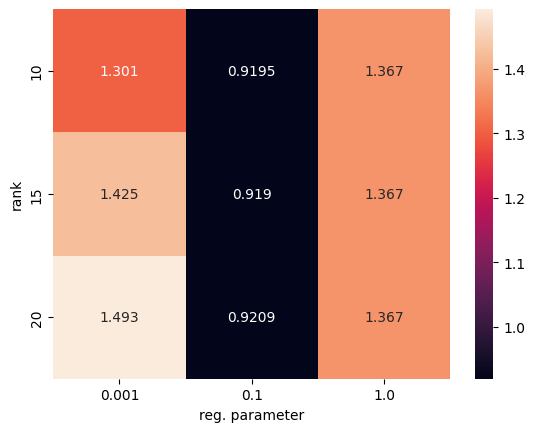

In [55]:
fig, ax = plt.subplots()
sns.heatmap(rmse_df, annot=True, fmt=".4g")

- **Lower RMSE values are better:** RMSE represents the root mean squared error, which is a measure of the difference between predicted and actual ratings. Lower RMSE values indicate that the model's predictions are closer to the actual ratings, implying better performance.
- **Color intensity:** The color intensity in the heatmap corresponds to the RMSE value. Darker colors generally represent lower RMSE values (better performance), while lighter colors indicate higher RMSE values (worse performance).

- 0.919 is the best RMSE-Score
  - reg. Param = 0.1
  - rank = 15

In [56]:
param_dict2 = {
    "rank": [10, 15, 20],
    "maxIter": [5, 10, 15]
}

# Generate a dictionary for each parameter combination which can then be fed into model training.
param_grid2 = generate_param_grid(param_dict2)

In [64]:
rmse_score2 = []

for g in param_grid2:
  als = ALS(userCol=COL_USER,
            itemCol=COL_ITEM,
        ratingCol=COL_RATING,
        coldStartStrategy="drop",
        **g # The **g syntax in Python is used to unpack a dictionary into keyword arguments when calling a function or initializing an object.
    )

  model = als.fit(dfs_train)

  dfs_pred = model.transform(dfs_test).drop(COL_RATING) #delete true ratings, prevent daya leak

  evaluations = SparkRatingEvaluation(
    dfs_test,
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )
  rmse_score2.append(evaluations.rmse())

rmse_score2 = [float('%4f' % x) for x in rmse_score2]  # formats each RMSE value in rmse_score to four decimal places. The result is a list where each RMSE score is rounded to four decimal places for better readability and precision.
rmse_score_array2 = np.reshape(rmse_score2, (len(param_dict2["rank"]), len(param_dict2["maxIter"])))

print(rmse_score_array2)

[[0.925197 0.92223  0.922759]
 [0.919521 0.919004 0.92089 ]
 [0.918443 0.918097 0.919892]]


<Axes: xlabel='maxIter', ylabel='rank'>

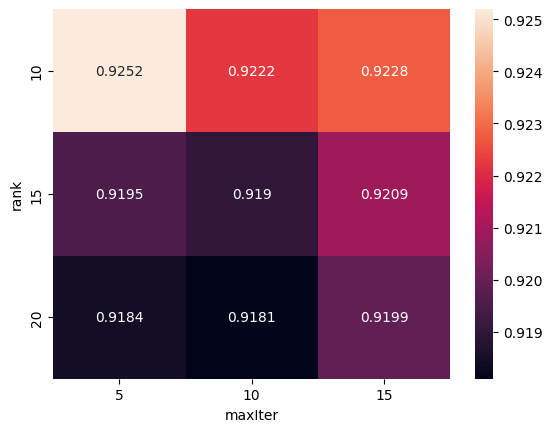

In [76]:
rmse_df2 = pd.DataFrame(data=rmse_score_array2, index=pd.Index(param_dict2["rank"], name="rank"),
                                                             columns=pd.Index(param_dict2["maxIter"], name="maxIter"))
fig, ax = plt.subplots()
sns.heatmap(rmse_df2, annot=True, fmt=".4g")

- 0.9181 the best RMSE-Score
   - maxIter = 10
   - rank = 20

In [69]:
param_dict3 = {
    "regParam": [0.001, 0.1, 1.0],
    "maxIter": [5, 10, 15]
}

# Generate a dictionary for each parameter combination which can then be fed into model training.
param_grid3 = generate_param_grid(param_dict3)

In [72]:
rmse_score3 = []

for g in param_grid3:
  als = ALS(userCol=COL_USER,
            itemCol=COL_ITEM,
        ratingCol=COL_RATING,
        coldStartStrategy="drop",
        **g # The **g syntax in Python is used to unpack a dictionary into keyword arguments when calling a function or initializing an object.
    )

  model = als.fit(dfs_train)

  dfs_pred = model.transform(dfs_test).drop(COL_RATING) #delete true ratings, prevent daya leak

  evaluations = SparkRatingEvaluation(
    dfs_test,
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )
  rmse_score3.append(evaluations.rmse())

rmse_score3 = [float('%4f' % x) for x in rmse_score3]  # formats each RMSE value in rmse_score to four decimal places. The result is a list where each RMSE score is rounded to four decimal places for better readability and precision.
rmse_score_array3 = np.reshape(rmse_score3, (len(param_dict3["regParam"]),len(param_dict3["maxIter"])))

print(rmse_score_array3)

[[1.228873 0.925197 1.36786 ]
 [1.301055 0.919521 1.366794]
 [1.344095 0.918443 1.366794]]


<Axes: xlabel='maxIter', ylabel='regParam'>

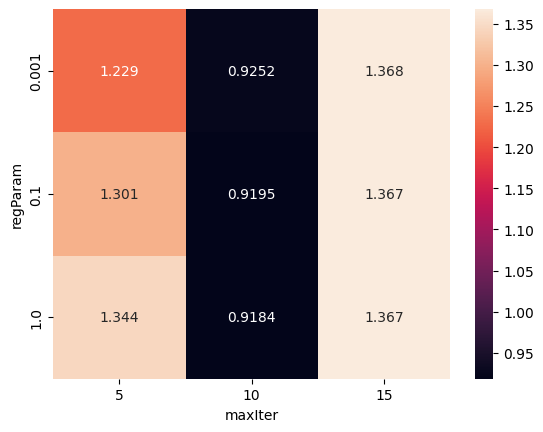

In [77]:
rmse_df3 = pd.DataFrame(data=rmse_score_array3, index=pd.Index(param_dict3["regParam"], name="regParam"),
                                                             columns=pd.Index(param_dict3["maxIter"], name="maxIter"))
fig, ax = plt.subplots()
sns.heatmap(rmse_df3, annot=True, fmt=".4g")

- 0.9184 the best RMSE-Score
   - maxIter = 10
   - regParam = 1.0

Comparison of all heatmaps:

1.  0.919 is the best RMSE-Score

    reg. Param = 0.1
    rank = 15

2. 0.9181 the best RMSE-Score

    maxIter = 10
    rank = 20

3. 0.9184 the best RMSE-Score
       
    maxIter = 10 regParam = 1.0

### 3.5 Top K recommendation

#### 3.5.1 Top k for all users (items)

`recommendForAllUsers(10)`: This is a method of the ALS model in Spark that generates recommendations for every user in your dataset.

In [78]:
dfs_rec = model.recommendForAllUsers(10)
dfs_rec.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|     1|[{1536, 3.8742251...|
|     3|[{1536, 3.0857244...|
|     5|[{1536, 3.1859274...|
|     6|[{1536, 3.709467}...|
|     9|[{1536, 4.2425303...|
|    12|[{1536, 4.4972663...|
|    13|[{1536, 3.4071121...|
|    15|[{1536, 3.1946425...|
|    16|[{1536, 4.5356526...|
|    17|[{1536, 3.1385803...|
+------+--------------------+
only showing top 10 rows



#### 3.5.2 Top k for a selected set of users (items)

In [79]:
selected_users = dfs_train.select(als.getUserCol()).distinct().limit(3)
dfs_rec_subset = model.recommendForUserSubset(selected_users, 10)

dfs_rec_subset.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|   471|[{1536, 3.263929}...|
|   463|[{1536, 3.127089}...|
|   148|[{1536, 3.8723612...|
+------+--------------------+



#### 3.5.3 Run-time considerations for top-k recommendations

It is worth noting that usually computing the top-k recommendations for all users is the bottleneck of the whole pipeline (model training and scoring) of an ALS based recommendation system. This is because
* *Getting the top k from all user-item pairs requires a cross join which is usually very computationally expensive.*
* Inner products of user-item pairs are calculated individually instead of leveraging matrix block multiplication features which are available in certain contemporary computing acceleration libraries (e.g., BLAS).

More details about possible optimizations of the top k recommendations in Spark can be found [here](https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html).